In [1]:
import os
import json
from tqdm import tqdm

def convert_imcoords_to_bbox(imcoords):
    # imcoords는 문자열 형태의 좌표를 파싱하여 리스트로 변환
    coords = list(map(float, imcoords.split(',')))
    x_values = coords[0::2]  # 짝수 인덱스는 x 좌표
    y_values = coords[1::2]  # 홀수 인덱스는 y 좌표
    
    # 좌표로부터 bbox의 중심 좌표(cx, cy), 너비(width), 높이(height) 계산
    x_min = min(x_values)
    x_max = max(x_values)
    y_min = min(y_values)
    y_max = max(y_values)
    
    cx = (x_min + x_max) / 2
    cy = (y_min + y_max) / 2
    width = x_max - x_min
    height = y_max - y_min
    
    return cx, cy, width, height

def filter_and_modify_json(directory, output_directory):
    # 지정된 디렉토리 내 모든 JSON 파일 확인
    for filename in tqdm(os.listdir(directory), desc="Processing files", unit="file"):
        if filename.endswith(".json"):
            input_file_path = os.path.join(directory, filename).replace('\\', '/')
            
            with open(input_file_path, 'r', encoding='utf-8') as file:
                data = json.load(file)
            
            # 새로운 피처 저장 리스트
            filtered_features = []

            # 'features' 필드가 있는지 확인하고 반복
            if 'features' in data:
                for feature in data['features']:
                    if 'properties' in feature:
                        type_name = feature['properties'].get('type_name')
                        
                        # 'type_name'이 'ship(S)' 또는 'ship(L)'인 경우만 처리
                        if type_name in ['ship(S)', 'ship(L)']:
                            imcoords = feature['properties'].get('object_imcoords')
                            if imcoords:
                                # 좌표 변환 후 새로운 값 추가
                                cx, cy, width, height = convert_imcoords_to_bbox(imcoords)
                                feature['properties']['cx'] = cx
                                feature['properties']['cy'] = cy
                                feature['properties']['width'] = width
                                feature['properties']['height'] = height
                                
                                # 기존 데이터와 함께 새로운 properties로 업데이트
                                filtered_features.append(feature)

            # 새로운 JSON 구조 생성
            if filtered_features:
                new_data = {
                    "type": "FeatureCollection",
                    "features": filtered_features
                }

                # 출력 경로 설정 (출력 폴더에 저장)
                output_file_path = os.path.join(output_directory, filename).replace('\\', '/')
                with open(output_file_path, 'w', encoding='utf-8') as outfile:
                    json.dump(new_data, outfile, ensure_ascii=False, indent=4)
import os
import json

def check_for_other_classes(directory):
    other_classes_found = False
    other_classes = set()

    # 지정된 디렉토리 내 모든 JSON 파일 확인
    for filename in os.listdir(directory):
        if filename.endswith(".json"):
            file_path = os.path.join(directory, filename).replace('\\', '/')
            
            with open(file_path, 'r', encoding='utf-8') as file:
                data = json.load(file)
            
            # 'features' 필드가 있는지 확인하고 반복
            if 'features' in data:
                for feature in data['features']:
                    if 'properties' in feature:
                        type_name = feature['properties'].get('type_name')
                        
                        # 'ship(S)' 또는 'ship(L)' 외의 다른 클래스가 있는지 확인
                        if type_name not in ['ship(S)', 'ship(L)']:
                            other_classes_found = True
                            other_classes.add(type_name)

    # 결과 출력
    if other_classes_found:
        print("다른 클래스가 발견되었습니다:", other_classes)
    else:
        print("모든 JSON 파일이 'ship(S)' 또는 'ship(L)'만 포함하고 있습니다.")

In [2]:
# Train
input_directory = './train_objects_labels'  # 입력 JSON 파일들이 있는 폴더
output_directory = './datasets/labels/train'  # 필터링 후 JSON 파일을 저장할 폴더

# 출력 폴더가 없으면 생성
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# 필터링 및 변환 실행
filter_and_modify_json(input_directory, output_directory)
check_for_other_classes(output_directory)

# valid
input_directory = './vaildate_objects_labels'  # 입력 JSON 파일들이 있는 폴더
output_directory = './datasets/labels/val'  # 필터링 후 JSON 파일을 저장할 폴더

# 출력 폴더가 없으면 생성
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# 필터링 및 변환 실행
filter_and_modify_json(input_directory, output_directory)
check_for_other_classes(output_directory)

Processing files: 100%|██████████| 1747/1747 [00:13<00:00, 129.37file/s]


모든 JSON 파일이 'ship(S)' 또는 'ship(L)'만 포함하고 있습니다.


Processing files: 100%|██████████| 219/219 [00:01<00:00, 139.84file/s]


모든 JSON 파일이 'ship(S)' 또는 'ship(L)'만 포함하고 있습니다.


In [3]:
train_list = os.listdir('./datasets/labels/train')
train_list.sort()
train_list[:3]

['OBJ00022_PS3_K3_NIA0078.json',
 'OBJ00028_PS3_K3_NIA0078.json',
 'OBJ00258_PS3_K3_NIA0081.json']

# Negative Samples 추가

In [4]:
import os
import json
from tqdm import tqdm
import random

def create_empty_ship_json(input_directory, output_directory, num_empty_files=80):
    # JSON 파일 목록에서 num_empty_files 개수만큼 무작위로 선택
    json_files = [f for f in os.listdir(input_directory) if f.endswith(".json")]
    selected_files = random.sample(json_files, min(num_empty_files, len(json_files)))
    
    # 배가 없는 빈 JSON 파일 생성
    for filename in tqdm(selected_files, desc="Creating empty ship files", unit="file"):
        empty_data = {
            "type": "FeatureCollection",
            "features": []
        }
        # 원래 파일 이름을 그대로 사용하여 출력
        output_file_path = os.path.join(output_directory, filename).replace('\\', '/')
        
        with open(output_file_path, 'w', encoding='utf-8') as outfile:
            json.dump(empty_data, outfile, ensure_ascii=False, indent=4)


In [5]:

# 예제 사용
input_directory = './train_objects_labels'  # 입력 JSON 파일들이 있는 폴더
output_directory = './datasets/labels/train'  # 필터링 후 JSON 파일을 저장할 폴더
create_empty_ship_json(input_directory, output_directory, num_empty_files=140)  # 원래 이름으로 빈 JSON 파일 생성


Creating empty ship files: 100%|██████████| 140/140 [00:00<00:00, 3583.45file/s]


# 이미지 복사

In [6]:
import os
import shutil
from tqdm import tqdm
import csv
import cv2

# .json 파일을 기반으로 .png 파일을 찾고, 해당 파일을 바로 복사하는 함수
def get_and_copy_img(json_path, img_path, save_dir):
    # save_dir이 없으면 디렉토리 생성
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # .json 파일을 기반으로 .png 파일을 찾아서 복사
    for filename in tqdm(os.listdir(json_path), desc="Processing files", unit="file"):
        # .json 파일명을 .png 파일명으로 변환
        png_file = filename.replace('.json', '.png')
        png_file = os.path.join(img_path, png_file).replace('\\', '/')
        
        # .png 파일이 존재하는지 확인하고, 존재하면 복사
        if os.path.exists(png_file):
            img = cv2.imread(png_file)
            
            cv2.imwrite(os.path.join(save_dir, png_file.split('/')[-1]), img)
            # shutil.copy(png_file, save_dir)
        else:
            print(f"Warning: {png_file} not found!")

In [7]:
# 사용 예시
json_train_dir = './datasets/labels/train'  # .json 파일들이 있는 디렉토리
img_train_dir = './train_objects_images'  # .png 파일들이 있는 디렉토리
save_dir = './datasets/images/train'  # .png 파일을 복사할 디렉토리
if not os.path.exists(save_dir):
    os.makedirs(save_dir)


# .json 파일을 기반으로 .png 파일을 찾고 바로 복사
get_and_copy_img(json_train_dir, img_train_dir, save_dir)

Processing files: 100%|██████████| 476/476 [00:27<00:00, 17.59file/s]


In [8]:
# 사용 예시
json_train_dir = './datasets/labels/val'  # .json 파일들이 있는 디렉토리
img_train_dir = './vaildate_objects_images'  # .png 파일들이 있는 디렉토리
save_dir = './datasets/images/val'  # .png 파일을 복사할 디렉토리
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
# .json 파일을 기반으로 .png 파일을 찾고 바로 복사
get_and_copy_img(json_train_dir, img_train_dir, save_dir)

Processing files: 100%|██████████| 37/37 [00:02<00:00, 17.54file/s]


# 경로 csv 파일 생성

In [9]:
# .json 파일과 .png 파일 경로를 리스트로 반환하는 함수
def get_img_json_list(json_path, img_path):
    img_json_list = []
    for filename in tqdm(os.listdir(json_path), desc="Processing files", unit="file"):
        # .json 파일명을 .png 파일명으로 변환
        json_file = os.path.join(json_path, filename).replace('\\', '/')
        png_file = filename.replace('.json', '.png')
        png_file = os.path.join(img_path, png_file).replace('\\', '/')

        # .png 파일이 실제로 존재하는지 확인 후 리스트에 추가
        if os.path.exists(png_file):
            img_json_list.append([png_file, json_file])
        else:
            print(f"Warning: {png_file} not found!")

    return img_json_list

# 추출된 경로 리스트를 CSV 파일로 저장하는 함수
def save_to_csv(data, output_csv):
    # CSV 파일로 저장
    with open(output_csv, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        # 헤더 작성
        writer.writerow(["Image", "JSON"])
        # 데이터 작성
        writer.writerows(data)

In [10]:
# 사용 예시
label_dir = './datasets/labels/train'  # .json 파일들이 있는 디렉토리
img_dir = './datasets/images/train'  # .png 파일들이 있는 디렉토리
output_csv = 'train.csv'  # 경로 정보를 저장할 CSV 파일명

# .json과 .png 경로 추출
img_json_list = get_img_json_list(label_dir, img_dir)

# 경로 정보를 CSV 파일로 저장
save_to_csv(img_json_list, output_csv)

Processing files: 100%|██████████| 476/476 [00:00<00:00, 21435.58file/s]


In [11]:
# 사용 예시
label_dir = './datasets/labels/val'  # .json 파일들이 있는 디렉토리
img_dir = './datasets/images/val'  # .png 파일들이 있는 디렉토리
output_csv = 'valid.csv'  # 경로 정보를 저장할 CSV 파일명

# .json과 .png 경로 추출
img_json_list = get_img_json_list(label_dir, img_dir)

# 경로 정보를 CSV 파일로 저장
save_to_csv(img_json_list, output_csv)

Processing files: 100%|██████████| 37/37 [00:00<00:00, 10529.87file/s]


# 배와 negative sampling 데이터 라벨 json->txt

In [12]:
import os
import csv
import json
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches
import numpy as np

# 유클리드 거리 계산 함수
def euclidean_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

def manhattan_distance(coords):
    x_values = coords[0::2]  # 짝수 인덱스는 x 좌표
    y_values = coords[1::2]  # 홀수 인덱스는 y 좌표
    
    # 좌표로부터 bbox의 중심 좌표(cx, cy), 너비(width), 높이(height) 계산
    x_min = min(x_values)
    x_max = max(x_values)
    y_min = min(y_values)
    y_max = max(y_values)

    width = x_max - x_min
    height = y_max - y_min
    
    return width, height


# JSON 파일을 읽어들이는 함수 (BBox 좌표와 angle 포함)
def get_bbox_from_json(json_file):
    with open(json_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    results = []
    
    if 'features' in data:
        for feature in data['features']:
            if 'properties' in feature:
                # object_imcoords를 파싱하여 좌표 추출
                imcoords = feature['properties'].get('object_imcoords', '')
                if imcoords:
                    coords = list(map(float, imcoords.split(',')))

                    # 맨해튼 거리 계산
                    # width, height = manhattan_distance(coords)

                    coords = np.array(coords).reshape(-1, 2)  # 2D 좌표로 변환

                    # 중심 좌표 계산
                    cx = np.mean(coords[:, 0])
                    cy = np.mean(coords[:, 1])

                    # 인접한 두 점으로부터 너비와 높이 계산
                    width = euclidean_distance(coords[0], coords[1])
                    height = euclidean_distance(coords[1], coords[2])

                    # 각도 추출
                    angle = feature['properties'].get('object_angle', 0.0)

                    # 회전된 바운딩 박스 좌표 저장 (cx, cy, width, height, angle)
                    results.append((cx, cy, width, height, angle))
    
    return results

def get_coords_from_json(json_file):
    with open(json_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    results = []
    
    if 'features' in data:
        for feature in data['features']:
            if 'properties' in feature:
                # object_imcoords를 파싱하여 좌표 추출
                imcoords = feature['properties'].get('object_imcoords', '')
                class_name = feature['properties'].get('type_name', '')
                
                if imcoords:
                    coords = list(map(float, imcoords.split(',')))

                    results.append((class_name,coords))
    return results

def save_coords_to_txt(coords_list, output_file, img_path):
    with open(output_file, 'w') as f:
        for coords in coords_list:
            class_name, coords = coords
            coords = np.array(coords) / 1024.0
    
             # 각 좌표값이 0 미만이면 0, 1 이상이면 1로 클리핑
            coords = np.clip(coords, 0, 1)

            x1, y1, x2, y2, x3, y3, x4, y4 = coords
            
            if class_name == 'ship(S)':
                f.write(f"0 {x1:.6f} {y1:.6f} {x2:.6f} {y2:.6f} {x3:.6f} {y3:.6f} {x4:.6f} {y4:.6f}\n")
            elif class_name == 'ship(L)': 
                f.write(f"1 {x1:.6f} {y1:.6f} {x2:.6f} {y2:.6f} {x3:.6f} {y3:.6f} {x4:.6f} {y4:.6f}\n")

# 바운딩 박스 정보를 txt 파일로 저장하는 함수
def save_bbox_to_txt(bbox_list, output_file, img_path):
    with open(output_file, 'w') as f:
        for bbox in bbox_list:
            cx, cy, width, height, angle = bbox
            cx, cy, width, height, angle = cx/1024, cy/1024, width/1024, height/1024, angle

            # if cx < 0 or cy < 0 or width < 0 or height < 0 or cx > 1 or cy > 1 or width > 1 or height > 1:
                # print(f"Warning: {img_path} - bbox가 이미지 밖으로 벗어납니다.")
                # visualize_image_with_bbox(img_path, bbox_list)
            if cx < 0 or cx > 1:
                cx = max(0, min(cx, 1))
            if cy < 0 or cy > 1:
                cy = max(0, min(cy, 1))
            if width < 0 or width > 1:
                width = max(0, min(width, 1))
            if height < 0 or height > 1:
                height = max(0, min(height, 1))

            f.write(f"0 {cx:.6f} {cy:.6f} {height:.6f} {width:.6f} {angle:.6f}\n")
            # f.write(f"0 {cx:.6f} {cy:.6f} {height:.6f} {width:.6f}\n")


def visualize_image_with_coords(image_path, coords_list):
    img = Image.open(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    for class_name, coords in coords_list:
        # coords: [x1, y1, x2, y2, x3, y3, x4, y4]
        coords = np.array(coords)
        coords = coords.reshape(4, 2)  # 4개의 좌표쌍 (x, y)으로 변환
        
        # 다각형 그리기 (4개의 좌표를 사용한 회전된 바운딩 박스)
        polygon = patches.Polygon(coords, closed=True, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(polygon)
        
        # 클래스 이름 표시 (옵션)
        cx, cy = np.mean(coords[:, 0]), np.mean(coords[:, 1])  # 중심 좌표
        ax.text(cx, cy, class_name, color='blue', fontsize=12, ha='center')

    plt.axis('off')
    plt.show()


# CSV에서 이미지 경로와 JSON 경로를 불러오는 함수
def load_csv(csv_path):
    data = []
    with open(csv_path, newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # 헤더 스킵
        for row in reader:
            img_path, json_path = row
            data.append((img_path, json_path))
    return data

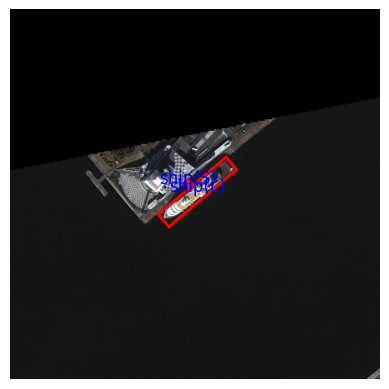

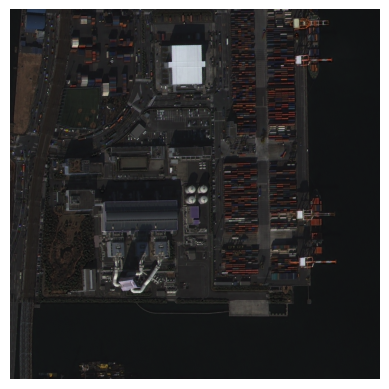

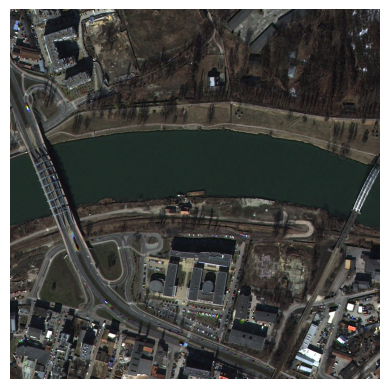

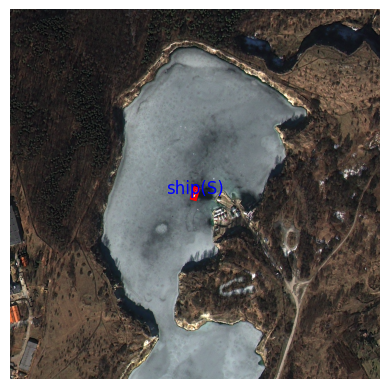

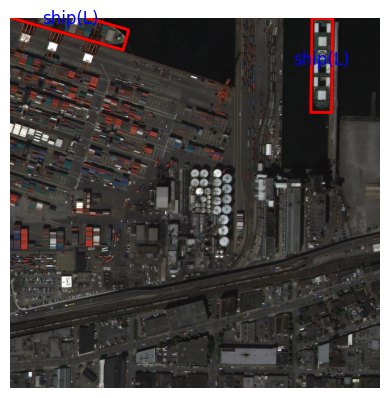

In [13]:
# 사용 예시
csv_path = 'train.csv'  # CSV 파일 경로
data = load_csv(csv_path)  # 이미지와 JSON 경로 불러오기

# 5개의 이미지와 바운딩 박스를 시각화하고, BBox 정보를 txt로 저장
for i, (img_path, json_path) in enumerate(data):
    if os.path.exists(img_path) and os.path.exists(json_path):
        bbox_list = get_coords_from_json(json_path)  # JSON에서 BBox 추출
        
        # .txt 파일로 저장할 파일명 정의
        output_file = json_path.replace('.json', '.txt')  # .json 파일명을 .txt로 변경
        save_coords_to_txt(bbox_list, output_file, img_path)  # bbox 정보를 txt로 저장
        
        if i < 5:
            # 이미지와 BBox 시각화
            visualize_image_with_coords(img_path, bbox_list)

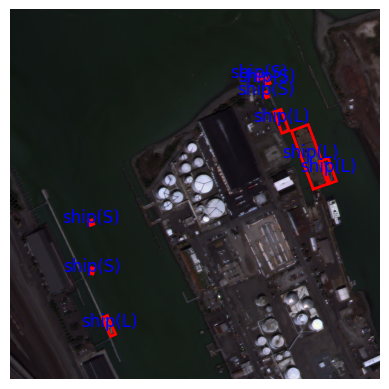

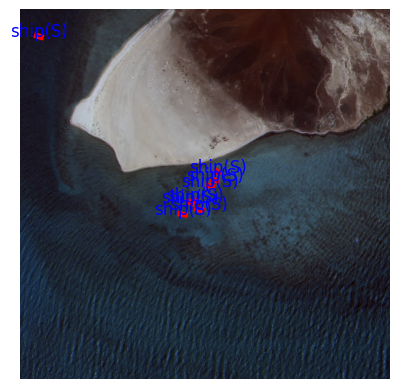

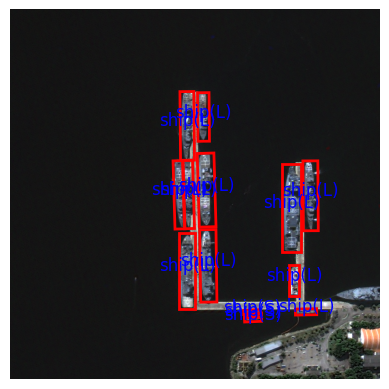

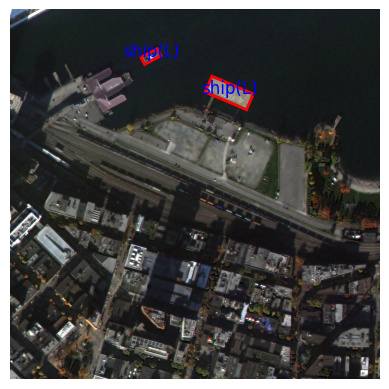

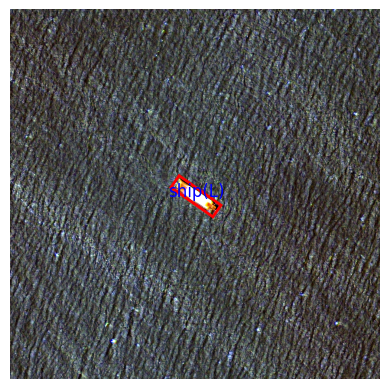

In [14]:
# 사용 예시
csv_path = 'valid.csv'  # CSV 파일 경로
data = load_csv(csv_path)  # 이미지와 JSON 경로 불러오기

# 5개의 이미지와 바운딩 박스를 시각화하고, BBox 정보를 txt로 저장
for i, (img_path, json_path) in enumerate(data):
    if os.path.exists(img_path) and os.path.exists(json_path):
        bbox_list = get_coords_from_json(json_path)  # JSON에서 BBox 추출
        
        # .txt 파일로 저장할 파일명 정의
        output_file = json_path.replace('.json', '.txt')  # .json 파일명을 .txt로 변경
        save_coords_to_txt(bbox_list, output_file, img_path)  # bbox 정보를 txt로 저장
        
        if i < 5:
            # 이미지와 BBox 시각화
            visualize_image_with_coords(img_path, bbox_list)


# 데이터셋 합치기

In [15]:
import os
import shutil

# 기존 클래스 ID에서 새 클래스 ID로 매핑
class_mapping = {
    0: 0,  # motorboat -> ship(s)
    1: 0,  # sailboat -> ship(s)
    2: 0,  # tugboat -> ship(L)
    3: 1,  # barge -> ship(L)
    4: 0,  # fishing boat -> ship(s)
    5: 1,  # ferry -> ship(L)
    6: 1,  # container ship -> ship(L)
    7: 1,  # oil tanker -> ship(L)
    8: 1,  # drill ship -> ship(L)
    9: 1,  # warship -> ship(L)
}

# 라벨과 이미지 원본 디렉터리
original_labels_dir = './dataset2/labels'
original_images_dir = './dataset2/images'

# 새로 복사할 디렉터리
new_labels_dir = './datasets/labels'
new_images_dir = './datasets/images'

# 폴더가 없는 경우 생성
if not os.path.exists(new_labels_dir):
    os.makedirs(new_labels_dir, exist_ok=True)
if not os.path.exists(new_images_dir):
    os.makedirs(new_images_dir, exist_ok=True)

# 라벨 파일을 업데이트하여 새 디렉터리에 저장하는 함수
def update_label_file(file_path, new_file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    new_lines = []
    for line in lines:
        parts = line.strip().split()
        original_class_id = int(parts[0])
        if original_class_id in class_mapping:
            new_class_id = class_mapping[original_class_id]
            parts[0] = str(new_class_id)
            new_line = ' '.join(parts)
            new_lines.append(new_line)
        else:
            print(f"경고: 클래스 ID {original_class_id}가 매핑에 없습니다.")
    
    # 새 라벨 파일로 저장
    os.makedirs(os.path.dirname(new_file_path), exist_ok=True)  # 하위 디렉터리 생성
    with open(new_file_path, 'w') as file:
        file.write('\n'.join(new_lines))

# 라벨 파일 업데이트 및 복사
for root, dirs, files in os.walk(original_labels_dir):
    for filename in files:
        if filename.endswith('.txt'):
            old_file_path = os.path.join(root, filename)
            # 기존 경로에서 새로운 라벨 경로로 변환 (dataset/labels/train, dataset/labels/val 등)
            relative_path = os.path.relpath(old_file_path, original_labels_dir)
            new_file_path = os.path.join(new_labels_dir, relative_path)
            update_label_file(old_file_path, new_file_path)
            print(f"{new_file_path} 업데이트 완료")

# 이미지 파일 복사
for root, dirs, files in os.walk(original_images_dir):
    for filename in files:
        if filename.endswith(('.png', '.jpg', '.jpeg')):  # 이미지 확장자에 따라 필터링
            old_file_path = os.path.join(root, filename)
            # 기존 경로에서 새로운 이미지 경로로 변환 (dataset/images/train, dataset/images/val 등)
            relative_path = os.path.relpath(old_file_path, original_images_dir)
            new_file_path = os.path.join(new_images_dir, relative_path)
            os.makedirs(os.path.dirname(new_file_path), exist_ok=True)  # 하위 디렉터리 생성
            shutil.copy2(old_file_path, new_file_path)
            print(f"{new_file_path} 이미지 복사 완료")


./datasets/labels\train\OBJ00032_PS3_K3_AIDATA0585.txt 업데이트 완료
./datasets/labels\train\OBJ00036_PS3_K3_AIDATA0585.txt 업데이트 완료
./datasets/labels\train\OBJ00059_PS3_K3_AIDATA0587.txt 업데이트 완료
./datasets/labels\train\OBJ00068_PS3_K3_AIDATA0587.txt 업데이트 완료
./datasets/labels\train\OBJ00111_PS3_K3A_AIDATA0589.txt 업데이트 완료
./datasets/labels\train\OBJ00115_PS3_K3A_AIDATA0591.txt 업데이트 완료
./datasets/labels\train\OBJ00116_PS3_K3A_AIDATA0591.txt 업데이트 완료
./datasets/labels\train\OBJ00117_PS3_K3A_AIDATA0591.txt 업데이트 완료
./datasets/labels\train\OBJ00118_PS3_K3A_AIDATA0591.txt 업데이트 완료
./datasets/labels\train\OBJ00121_PS3_K3A_AIDATA0591.txt 업데이트 완료
./datasets/labels\train\OBJ00123_PS3_K3A_AIDATA0591.txt 업데이트 완료
./datasets/labels\train\OBJ00124_PS3_K3A_AIDATA0591.txt 업데이트 완료
./datasets/labels\train\OBJ00125_PS3_K3A_AIDATA0591.txt 업데이트 완료
./datasets/labels\train\OBJ00126_PS3_K3A_AIDATA0591.txt 업데이트 완료
./datasets/labels\train\OBJ00134_PS3_K3_AIDATA0594.txt 업데이트 완료
./datasets/labels\train\OBJ00137_PS3_K3_AIDAT